In [33]:
# === 設定 ===
CHOICE = "POD"   # "POD" か "ACC"
YEAR   = 2020    # 先生コードと同じ条件
ROOT   = Path("data")  # あなたの data/ のルート

# === ファイル探索 ===
if CHOICE.upper() == "POD":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "POD" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
        "validity_flag": "validity_flag",
        "density_orbitmean": "density_orbitmean",
    }
    bin_secs = 30      # 30秒 -> 2880点
elif CHOICE.upper() == "ACC":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "ACC" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
    }
    bin_secs = 10      # 10秒 -> 8640点
else:
    raise ValueError("CHOICE must be 'POD' or 'ACC'")

print(f"Found {len(files)} {CHOICE} files in {YEAR}")

# === まずは「日ごとの生データ」を全ファイルから集約 ===
#  { 'YYYY-MM-DD': [DataFrame(その日の切り出し), ...] }
day_slices = {}

for f in files:
    df = read_cdf_to_df(f, time_var="time", var_map=var_map)

    # DNSに入れたいコア列だけ（存在するものを採用）
    core_cols = [c for c in ["density","altitude","latitude","longitude","local_solar_time"] if c in df.columns]

    # ファイル内に含まれるユニークな日付
    for d in sorted({ts.date() for ts in df.index}):
        date_str = str(d)

        # その日の生データを切り出し（必要な列だけ）
        day_df = df.loc[df.index.date == d, core_cols].copy()

        # 集約（複数ファイルに跨る同日分をここへ貯める）
        day_slices.setdefault(date_str, []).append(day_df)

# === 集約した生データを「同一日で結合」→ その後にグリッド化 → DNSへ ===
DNS = {}  # {doy: {"data": DataFrame, "ymd": ndarray, "date": 'YYYY-MM-DD'}}

for date_str in sorted(day_slices.keys()):
    # 同一日の生データを縦結合 → 時間順に整列 → 重複時刻は最後を採用
    raw_day = pd.concat(day_slices[date_str], axis=0).sort_index()
    if not raw_day.index.is_unique:
        raw_day = raw_day[~raw_day.index.duplicated(keep="last")]

    # 等間隔グリッド化（bin_one_day は空区間を NaN で埋めて固定長にする）
    binned = bin_one_day(raw_day, date_str, secs=bin_secs, cols=list(raw_day.columns))

    # doy（1始まり）
    doy = (pd.Timestamp(date_str) - pd.Timestamp(f"{YEAR}-01-01")).days + 1

    # 同じdoyが既にあるのは想定外（ここで検出して明示停止）
    if doy in DNS:
        raise ValueError(f"Duplicate DOY detected after aggregation: {doy} ({date_str}). "
                            f"Check file set or YEAR/CHOICE filters.")

    # 小数日 T
    seconds = (binned.index - pd.Timestamp(date_str)).total_seconds()
    T = (doy - 1) + seconds / 86400.0

    # ymd = [Y M D h m s]
    ymd = np.column_stack([
        np.full(len(binned), int(date_str[:4])),
        np.full(len(binned), int(date_str[5:7])),
        np.full(len(binned), int(date_str[8:10])),
        binned.index.hour, binned.index.minute, binned.index.second
    ])

    out = binned.copy()
    out["T"] = T
    DNS[doy] = {"data": out, "ymd": ymd, "date": date_str}

print(f"Days collected: {len(DNS)}")

# === 保存（pickle） ===
import pickle
save_path = Path(f"DNS_{CHOICE}_{YEAR}.pkl")
with open(save_path, "wb") as f:
    pickle.dump(DNS, f)
print("Saved:", save_path)


Found 121 POD files in 2020
Days collected: 121
Saved: DNS_POD_2020.pkl


[OK] 画像を保存しました -> figs/alt_days_debug.png


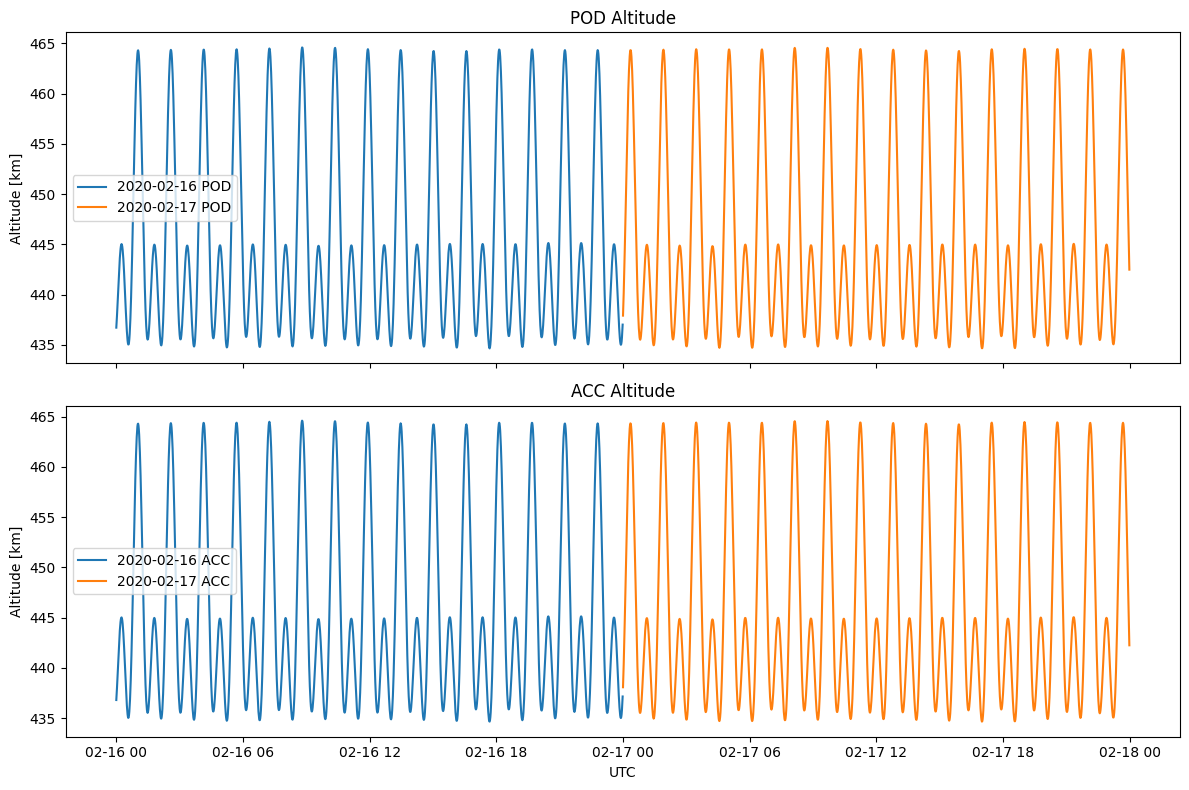

In [40]:
import os
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import date
import pickle

# --- ロード（パスは必要に応じて調整） ---
DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))

YEAR = 2020
OUTDIR = Path("figs"); OUTDIR.mkdir(exist_ok=True)

def _doy(d: date) -> int:
    return (pd.Timestamp(d) - pd.Timestamp(f"{YEAR}-01-01")).days + 1

def _get_day_df(DNS: dict, d: date, col="altitude"):
    k = _doy(d)
    if k not in DNS:
        return None
    df = DNS[k]["data"]
    return df[[col]] if col in df.columns else None

def _get_month_df(DNS: dict, year: int, month: int, col="altitude"):
    last = calendar.monthrange(year, month)[1]
    frames = []
    for day in range(1, last+1):
        k = (pd.Timestamp(f"{year}-{month:02d}-{day:02d}") - pd.Timestamp(f"{year}-01-01")).days + 1
        if k in DNS and col in DNS[k]["data"].columns:
            frames.append(DNS[k]["data"][[col]])
    if not frames:
        return None
    df = pd.concat(frames).sort_index()
    df.index.name = "time"
    return df

def plot_altitude_days_save(dates, which="both", resample=None, sharey=True, fname="alt_days.png"):
    show_pod = which.lower() in ("pod", "both")
    show_acc = which.lower() in ("acc", "both")

    n_axes = 1 if (show_pod ^ show_acc) else 2
    fig, axes = plt.subplots(n_axes, 1, figsize=(12, 4*n_axes), sharex=True, sharey=sharey)
    if n_axes == 1:
        axes = [axes]

    plotted = False

    # POD
    if show_pod:
        ax = axes[0]
        for d in dates:
            df = _get_day_df(DNS_POD, d, "altitude")
            if df is None:
                print(f"[WARN] POD: {d} にデータなし")
                continue
            s = df["altitude"].copy()
            if resample: s = s.resample(resample).mean()
            ax.plot(s.index, s/1000, label=f"{d} POD"); plotted = True
        ax.set_ylabel("Altitude [km]"); ax.set_title("POD Altitude"); ax.legend()

    # ACC
    if show_acc:
        ax = axes[-1] if show_pod else axes[0]
        for d in dates:
            df = _get_day_df(DNS_ACC, d, "altitude")
            if df is None:
                print(f"[WARN] ACC: {d} にデータなし")
                continue
            s = df["altitude"].copy()
            if resample: s = s.resample(resample).mean()
            ax.plot(s.index, s/1000, label=f"{d} ACC"); plotted = True
        ax.set_ylabel("Altitude [km]"); ax.set_title("ACC Altitude"); ax.legend()

    axes[-1].set_xlabel("UTC")
    plt.tight_layout()

    if not plotted:
        print("[ERROR] プロット対象データが1本も見つかりませんでした。日付や pickle の場所を確認してください。")
        plt.close(fig); return

    out_path = OUTDIR / fname
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    print(f"[OK] 画像を保存しました -> {out_path}")
    plt.show()

def plot_altitude_months_save(months, which="both", resample="5min", fname="alt_months.png"):
    show_pod = which.lower() in ("pod", "both")
    show_acc = which.lower() in ("acc", "both")

    n_axes = 1 if (show_pod ^ show_acc) else 2
    fig, axes = plt.subplots(n_axes, 1, figsize=(12, 4*n_axes), sharex=False)

    if n_axes == 1:
        axes = [axes]

    plotted = False

    # POD
    if show_pod:
        ax = axes[0]
        for m in months:
            df = _get_month_df(DNS_POD, YEAR, m, "altitude")
            if df is None:
                print(f"[WARN] POD: {YEAR}-{m:02d} にデータなし")
                continue
            s = df["altitude"].resample(resample).mean()
            ax.plot(s.index, s/1000, label=f"{YEAR}-{m:02d}"); plotted = True
        ax.set_ylabel("Altitude [km]"); ax.set_title("POD Altitude – Monthly"); ax.legend()

    # ACC
    if show_acc:
        ax = axes[-1] if show_pod else axes[0]
        for m in months:
            df = _get_month_df(DNS_ACC, YEAR, m, "altitude")
            if df is None:
                print(f"[WARN] ACC: {YEAR}-{m:02d} にデータなし")
                continue
            s = df["altitude"].resample(resample).mean()
            ax.plot(s.index, s/1000, label=f"{YEAR}-{m:02d}"); plotted = True
        ax.set_ylabel("Altitude [km]"); ax.set_title("ACC Altitude – Monthly"); ax.legend()

    axes[-1].set_xlabel("UTC")
    plt.tight_layout()

    if not plotted:
        print("[ERROR] プロット対象データが1本も見つかりませんでした。月や pickle の場所を確認してください。")
        plt.close(fig); return

    out_path = OUTDIR / fname
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    print(f"[OK] 画像を保存しました -> {out_path}")
    plt.show()
from datetime import date
plot_altitude_days_save([date(2020,2,16), date(2020,2,17)],
                        which="both", resample="1min",
                        fname="alt_days_debug.png")

